In [3]:
!pip install yfinance ta pandas numpy sklearn matplotlib scipy tqdm

In [4]:
import pandas as pd
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from ta import add_all_ta_features
import warnings
from scipy.signal import argrelextrema


## helper functions

In [5]:
# get ticker data from yahoo finance
def getData(ticker: str, start: date, end: date = date.today()) -> pd.DataFrame:
    df = yf.download(ticker, start, end)
    # add some ta
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df = add_all_ta_features(
            df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    df["SMA_3"] = df["Adj Close"].rolling(window=3).mean()
    df["SMA_10"] = df["Adj Close"].rolling(window=10).mean()
    df["SMA_50"] = df["Adj Close"].rolling(window=50).mean()
    df["SMA_200"] = df["Adj Close"].rolling(window=200).mean()
    # crosses
    df["SMA_3_10_cross"] = np.where(df["SMA_3"] > df["SMA_10"], 1, 0)
    df["SMA_50_200_cross"] = np.where(df["SMA_50"] > df["SMA_200"], 1, 0)
    # deal with nan values
    df = df.fillna(method="bfill")  # backwards fill nan values
    df = df.fillna(0)  # fill remaining nan values with 0
    # assert that we do not have any nan left
    assert df.isnull().sum().sum() == 0
    return df

In [6]:
# create a signal based on local minima and maxima
def getTrend(df: pd.DataFrame) -> pd.DataFrame:
    price = df["Adj Close"]
    # smoothed moving average
    price = price.rolling(window=20).mean()
    price = price.fillna(method='bfill')
    # for local maxima
    maxima = argrelextrema(price.values, np.greater)

    # for local minima
    minima = argrelextrema(price.values, np.less)
    # convert that to a target variable
    signal = np.zeros(len(price))
    ## if maxima contains the smallest i lastSignal is 1, else if minima contains the smallest i lastSignal is -1
    min_min = min(minima[0])
    min_max = min(maxima[0])
    if min_min < min_max:
        lastSignal = -1
    elif min_min > min_max:
        lastSignal = 1
    else:
        raise ValueError("minima and maxima are equal")
    
    for i in range(len(price)):
        if i in maxima[0]:
            lastSignal = -1
        elif i in minima[0]:
            lastSignal = 1
        signal[i] = lastSignal
    df["signal"] = signal
    return df

## get the data

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

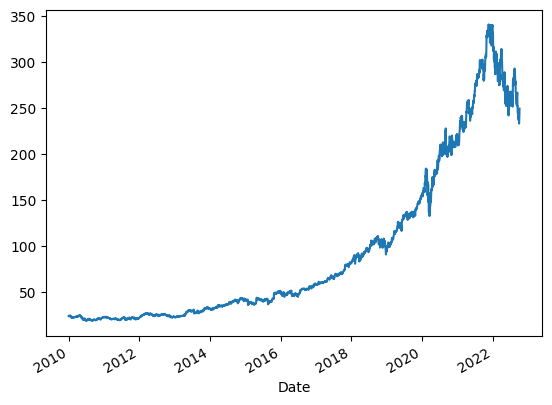

In [7]:
msft = getData("MSFT", date(2010, 1, 1))
msft = getTrend(msft)

msft["Adj Close"].plot()

## get some baseline

if we would just hold AAPL, how much would we have earned?

In [8]:
startMoney = 10000
COMMISSION = 0.00025 # interactive brokers commission
howmany = startMoney / msft.iloc[0]["Adj Close"]
win = howmany * msft.iloc[-1]["Adj Close"] - startMoney

days = (msft.index[-1] - msft.index[0]).days

print("with just holding you would have made %.2f$" % win)
winPerMonth = win / (days / 30)
winPctPerYear = winPerMonth * 12 / startMoney * 100
print("or %.2f%% per year" % winPctPerYear)
print("or %.2f$ per month" % winPerMonth)

with just holding you would have made 96545.12$
or 74.57% per year
or 621.40$ per month


## simulating a trade

In [9]:
X, Y = msft.drop(["signal"], axis=1), msft["signal"]
df = msft

In [10]:
def oneRun(model, lookbackarray = [1]):
    global X, df
    preds = model.predict(X)
    # print("the predictions are: ", np.unique(preds, return_counts=True))
    bestLookback = -1
    bestLookbackWin = -9999
    bestLookbackPortfolio = []
    for lookback in lookbackarray: # range(0, 5):
        money = startMoney
        nrStocks = 0
        portfolio = []
        for i in range(lookback, len(df)):
            if lookback > 0:
                prednow = np.median(preds[i-lookback:i+1])
            else:
                prednow = preds[i]
            # "translate" 0 to -1 like we did it before
            if prednow == 0:
                prednow = -1
            # print("prednow is, " , prednow)
            # prednow = preds[i]
            if prednow == 1 and nrStocks == 0 and money > 10:
                # buy
                howmany = money / df.iloc[i]["Adj Close"] * .99
                cost = howmany * df.iloc[i]["Adj Close"] * (1 + COMMISSION)
                money -= cost
                nrStocks += howmany
            elif prednow == -1 and nrStocks > 0:
                money += nrStocks * df.iloc[i]["Adj Close"] * (1 - COMMISSION)
                nrStocks = 0
            portfolio.append(money + nrStocks * df.iloc[i]["Adj Close"])
        # last day sell
        money += nrStocks * df.iloc[-1]["Adj Close"] * (1 - COMMISSION)
        win = money - startMoney
        if win > bestLookbackWin:
            bestLookback = lookback
            bestLookbackWin = win
            bestLookbackPortfolio = portfolio
    return bestLookbackWin, bestLookback, bestLookbackPortfolio


In [11]:
from random import random
class FakeModel:
    def predict(self, X):
        # random decision for demo purposes
        preds = []
        for i in range(len(X)):
            if random() > .5:
                preds.append(1)
            else:
                preds.append(-1)
        return preds

In [12]:
bestLookbackWin, bestLookback, bestLookbackPortfolio = oneRun(FakeModel())
print("with just holding you would have made %.2f$, using a lookback of %d" % (bestLookbackWin, bestLookback))
winPerMonth = bestLookbackWin / (days / 30)
winPctPerYear = winPerMonth * 12 / startMoney * 100
print("or %.2f%% per year" % winPctPerYear)
print("or %.2f$ per month" % winPerMonth)

with just holding you would have made 1461.83$, using a lookback of 1
or 1.13% per year
or 9.41$ per month


## using a decision tree to get a good result

In [13]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
clf = DecisionTreeClassifier()
clf.fit(X, Y)
scr = clf.score(X, Y)
print("score is: ", scr)
bestLookbackWin, bestLookback, bestLookbackPortfolio = oneRun(clf, lookbackarray = [1,3,5,10])

print("with just holding you would have made %.2f$, using a lookback of %d" % (bestLookbackWin, bestLookback))
winPerMonth = bestLookbackWin / (days / 30)
winPctPerYear = winPerMonth * 12 / startMoney * 100
print("or %.2f%% per year" % winPctPerYear)
print("or %.2f$ per month" % winPerMonth)

score is:  1.0
with just holding you would have made 227430.13$, using a lookback of 1
or 175.66% per year
or 1463.83$ per month


wowwwwwwwwwww +663% per year?!?! let me buy a villa in the bahamas!!!

As you might have assumed before the Decision Tree heavily overfits. Meaning it will perform quite good on seen data, but very poor on unseen data. 
This is why you should always do train test splits with your data, and test it on test data.

In this case we want to just "use" a Decision Tree to help us find some technical indicator assumptions. Therefore our plan is to "dump down" a decision tree, until the combination of performance and complexity are good enough to have a generalized estimator.

In [14]:
## use a lot of data to avoid only having assumptions of the AAPL stock

bigDf = []
for ticker in ["CWEG.L", "IWDA.AS", "EEM", "AAPL", "MSFT", "GOOG", "TSLA", 'AMD', 'AMZN', 'DG', "ETH-USD", "BTC-USD"]:
    print("geddin stock: " + ticker)
    tmp = getData(ticker = ticker, start = date(2010,1,1))
    tmp = getTrend(tmp)
    bigDf.append(tmp)
    
bigDf = pd.concat(bigDf)
bigDf.shape

geddin stock: CWEG.L
[*********************100%***********************]  1 of 1 completed
geddin stock: IWDA.AS
[*********************100%***********************]  1 of 1 completed
geddin stock: EEM
[*********************100%***********************]  1 of 1 completed
geddin stock: AAPL
[*********************100%***********************]  1 of 1 completed
geddin stock: MSFT
[*********************100%***********************]  1 of 1 completed
geddin stock: GOOG
[*********************100%***********************]  1 of 1 completed
geddin stock: TSLA
[*********************100%***********************]  1 of 1 completed
geddin stock: AMD
[*********************100%***********************]  1 of 1 completed
geddin stock: AMZN
[*********************100%***********************]  1 of 1 completed
geddin stock: DG
[*********************100%***********************]  1 of 1 completed
geddin stock: ETH-USD
[*********************100%***********************]  1 of 1 completed
geddin stock: BTC-USD
[*****

(36687, 99)

In [15]:
Xbig, Ybig = bigDf.drop(["signal"], axis=1), bigDf["signal"]


In [16]:
from tqdm import tqdm

bestDepth = -1
bestLeafes = -1
bestLookback = -1
bestDepthWin = -9999
collection = []
# explicitly force a max of 20 to prevent overfitting
for depth in tqdm([100,70,50,40,30,20,15]):
    for leafes in [100,70,50,40,30,20,15]:
        clf = DecisionTreeClassifier(max_depth=depth, max_leaf_nodes = leafes)
        # train with bigdf, test with df (all world)
        clf.fit(Xbig, Ybig)
        # scr = clf.score(X, Y)
        # print("score is: ", scr)
        bestLookbackWin, lookback, bestLookbackPortfolio = oneRun(clf, lookbackarray = [0,1,3,5,10])
        collection.append([depth,leafes,lookback,bestLookbackWin])
        if bestLookbackWin >= (bestDepthWin*.95): # equal to prefer smaller trees, 95% to accept a bit worse for smaller trees
            bestDepthWin = bestLookbackWin
            bestDepth = depth
            bestLeafes = leafes
            bestLookback = lookback
print("the best depth is %d, best leave %d, best lookback %d. with a win of %.2f$" % (bestDepth, bestLeafes, bestLookback, bestDepthWin))

100%|██████████| 7/7 [02:56<00:00, 25.24s/it]

the best depth is 15, best leave 70, best lookback 3. with a win of 31677.42$


In [17]:
collection = pd.DataFrame(collection, columns=["depth", "leafes", "lookback", "win"])
collection = collection.sort_values(by="win", ascending=False)
collection.head(20)

,depth,leafes,lookback,win
8,70,70,3,31677.423622
36,20,70,3,31677.423622
15,50,70,3,31677.423622
1,100,70,3,31677.423622
29,30,70,3,31677.423622
22,40,70,3,31677.423622
43,15,70,3,31677.423622
7,70,100,3,29232.039164
21,40,100,3,29232.039164
35,20,100,3,29232.039164


### visualize the best combination

In [18]:
from sklearn import metrics

clf = DecisionTreeClassifier(max_depth=bestDepth, max_leaf_nodes = bestLeafes)
clf.fit(Xbig, Ybig)
preds = clf.predict(X)
print(metrics.classification_report(df["signal"], preds))
print(metrics.confusion_matrix(df["signal"], preds))

              precision    recall  f1-score   support

        -1.0       0.85      0.90      0.87      1178
         1.0       0.94      0.91      0.92      2035

    accuracy                           0.91      3213
   macro avg       0.90      0.90      0.90      3213
weighted avg       0.91      0.91      0.91      3213

[[1058  120]
 [ 185 1850]]


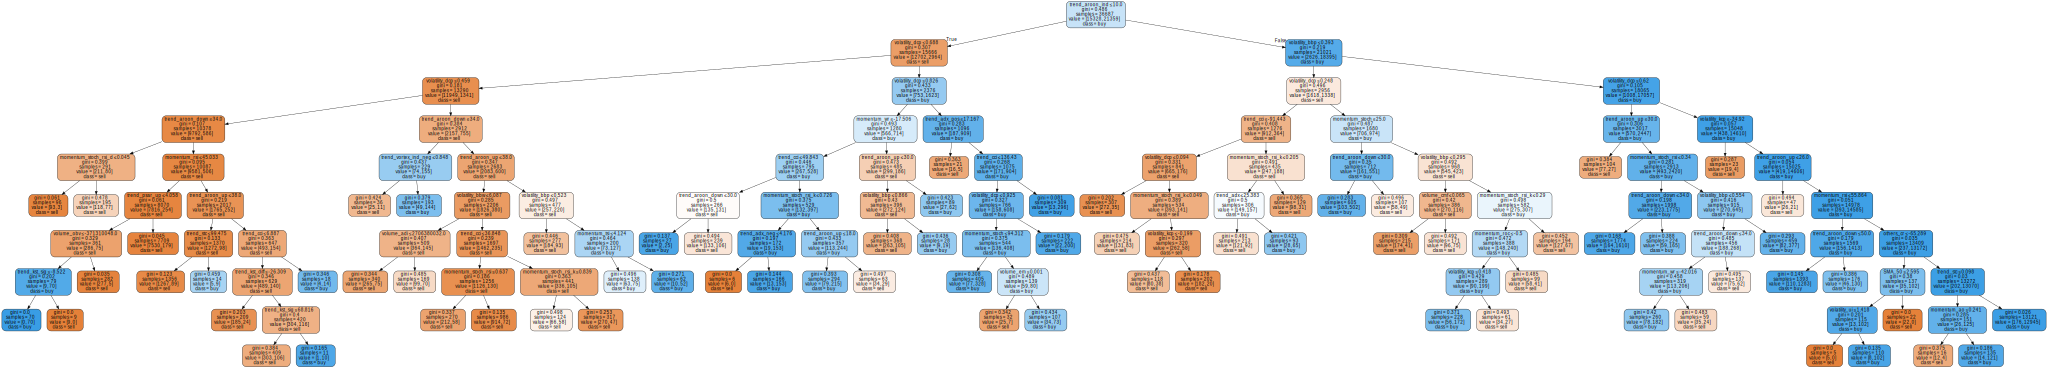

In [19]:
import graphviz 
dot_data = export_graphviz(clf, out_file=None,
                        feature_names=X.columns,  
                        class_names=["sell", "buy"],
                        filled=True, rounded=True,
                        special_characters=True) 
graph = graphviz.Source(dot_data) 
graph

In [20]:
bestLookbackWin, lookback, bestLookbackPortfolio = oneRun(clf, lookbackarray = [3])

print("with the decision tree you would have made %.2f$" % bestLookbackWin)
winPerMonth = bestLookbackWin / (days / 30)
winPctPerYear = winPerMonth * 12 / startMoney * 100
print("or %.2f%% per year" % winPctPerYear)
print("or %.2f$ per month" % winPerMonth)

with the decision tree you would have made 31677.42$
or 24.47% per year
or 203.89$ per month


In [21]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    feature_names = [f.replace(" ", "_")[:-5] for f in feature_names]
    print("def getDecision(dfrow):")

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if dfrow['{}'] <= {}:".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if dfrow['{}'] > {}".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, np.argmax(tree_.value[node][0])))

    recurse(0, 1)
# tree_to_code(clf, x_train.columns)

In [22]:
tree_to_code(clf, Xbig.columns)

def getDecision(dfrow):
    if dfrow['trend_aroon_ind'] <= 10.0:
        if dfrow['volatility_dcp'] <= 0.69:
            if dfrow['volatility_dcp'] <= 0.46:
                if dfrow['trend_aroon_down'] <= 34.0:
                    if dfrow['momentum_stoch_rsi_d'] <= 0.04:
                        return 0
                    else:  # if dfrow['momentum_stoch_rsi_d'] > 0.04
                        return 0
                else:  # if dfrow['trend_aroon_down'] > 34.0
                    if dfrow['momentum_rsi'] <= 45.03:
                        if dfrow['trend_psar_up'] <= 4.06:
                            if dfrow['volume_obv'] <= -371310048.0:
                                if dfrow['trend_kst_sig'] <= -8.52:
                                    return 1
                                else:  # if dfrow['trend_kst_sig'] > -8.52
                                    return 0
                            else:  # if dfrow['volume_obv'] > -371310048.0
                                return 0


In [23]:
def getDecision(dfrow):
    if dfrow['trend_aroon_ind'] <= 10.0:
        if dfrow['volatility_dcp'] <= 0.69:
            if dfrow['volatility_dcp'] <= 0.46:
                if dfrow['trend_aroon_down'] <= 34.0:
                    if dfrow['momentum_stoch_rsi_d'] <= 0.04:
                        return 0
                    else:  # if dfrow['momentum_stoch_rsi_d'] > 0.04
                        if dfrow['trend_kst_diff'] <= 15.39:
                            return 0
                        else:  # if dfrow['trend_kst_diff'] > 15.39
                            if dfrow['momentum_stoch_rsi_k'] <= 0.69:
                                return 1
                            else:  # if dfrow['momentum_stoch_rsi_k'] > 0.69
                                return 0
                else:  # if dfrow['trend_aroon_down'] > 34.0
                    if dfrow['momentum_rsi'] <= 45.03:
                        if dfrow['trend_psar_up'] <= 4.06:
                            if dfrow['volume_obv'] <= -371310048.0:
                                return 1
                            else:  # if dfrow['volume_obv'] > -371310048.0
                                return 0
                        else:  # if dfrow['trend_psar_up'] > 4.06
                            if dfrow['trend_cci'] <= 19.93:
                                return 0
                            else:  # if dfrow['trend_cci'] > 19.93
                                return 1
                    else:  # if dfrow['momentum_rsi'] > 45.03
                        if dfrow['trend_aroon_up'] <= 38.0:
                            if dfrow['trend_stc'] <= 99.48:
                                return 0
                            else:  # if dfrow['trend_stc'] > 99.48
                                return 1
                        else:  # if dfrow['trend_aroon_up'] > 38.0
                            if dfrow['trend_cci'] <= 6.89:
                                return 0
                            else:  # if dfrow['trend_cci'] > 6.89
                                return 1
            else:  # if dfrow['volatility_dcp'] > 0.46
                if dfrow['trend_aroon_down'] <= 34.0:
                    if dfrow['trend_vortex_ind_neg'] <= 0.85:
                        return 0
                    else:  # if dfrow['trend_vortex_ind_neg'] > 0.85
                        return 1
                else:  # if dfrow['trend_aroon_down'] > 34.0
                    if dfrow['trend_aroon_up'] <= 38.0:
                        if dfrow['volatility_bbw'] <= 6.09:
                            if dfrow['volume_adi'] <= 2706380032.0:
                                return 0
                            else:  # if dfrow['volume_adi'] > 2706380032.0
                                return 0
                        else:  # if dfrow['volatility_bbw'] > 6.09
                            if dfrow['trend_cci'] <= 36.85:
                                return 0
                            else:  # if dfrow['trend_cci'] > 36.85
                                return 0
                    else:  # if dfrow['trend_aroon_up'] > 38.0
                        if dfrow['volatility_bbp'] <= 0.52:
                            if dfrow['trend_macd'] <= 0.04:
                                return 0
                            else:  # if dfrow['trend_macd'] > 0.04
                                return 0
                        else:  # if dfrow['volatility_bbp'] > 0.52
                            if dfrow['momentum_tsi'] <= 4.12:
                                return 1
                            else:  # if dfrow['momentum_tsi'] > 4.12
                                return 1
        else:  # if dfrow['volatility_dcp'] > 0.69
            if dfrow['volatility_dcp'] <= 0.83:
                if dfrow['momentum_stoch'] <= 82.49:
                    if dfrow['trend_cci'] <= 49.84:
                        if dfrow['trend_aroon_down'] <= 30.0:
                            return 1
                        else:  # if dfrow['trend_aroon_down'] > 30.0
                            if dfrow['momentum_rsi'] <= 56.67:
                                return 0
                            else:  # if dfrow['momentum_rsi'] > 56.67
                                return 1
                    else:  # if dfrow['trend_cci'] > 49.84
                        if dfrow['momentum_stoch_rsi_k'] <= 0.73:
                            if dfrow['momentum_stoch_rsi_k'] <= 0.1:
                                return 0
                            else:  # if dfrow['momentum_stoch_rsi_k'] > 0.1
                                return 1
                        else:  # if dfrow['momentum_stoch_rsi_k'] > 0.73
                            if dfrow['trend_aroon_up'] <= 18.0:
                                return 1
                            else:  # if dfrow['trend_aroon_up'] > 18.0
                                return 0
                else:  # if dfrow['momentum_stoch'] > 82.49
                    if dfrow['trend_aroon_up'] <= 30.0:
                        if dfrow['volatility_bbp'] <= 0.87:
                            return 0
                        else:  # if dfrow['volatility_bbp'] > 0.87
                            return 1
                    else:  # if dfrow['trend_aroon_up'] > 30.0
                        return 1
            else:  # if dfrow['volatility_dcp'] > 0.83
                if dfrow['trend_adx_pos'] <= 17.17:
                    return 0
                else:  # if dfrow['trend_adx_pos'] > 17.17
                    if dfrow['trend_cci'] <= 136.43:
                        if dfrow['volatility_dcp'] <= 0.92:
                            if dfrow['momentum_stoch'] <= 94.31:
                                return 1
                            else:  # if dfrow['momentum_stoch'] > 94.31
                                return 1
                        else:  # if dfrow['volatility_dcp'] > 0.92
                            return 1
                    else:  # if dfrow['trend_cci'] > 136.43
                        return 1
    else:  # if dfrow['trend_aroon_ind'] > 10.0
        if dfrow['volatility_bbp'] <= 0.39:
            if dfrow['volatility_dcp'] <= 0.25:
                if dfrow['trend_cci'] <= -91.44:
                    if dfrow['volatility_dcp'] <= 0.09:
                        return 0
                    else:  # if dfrow['volatility_dcp'] > 0.09
                        if dfrow['momentum_stoch_rsi_k'] <= 0.05:
                            return 0
                        else:  # if dfrow['momentum_stoch_rsi_k'] > 0.05
                            if dfrow['volatility_kcp'] <= -0.2:
                                return 0
                            else:  # if dfrow['volatility_kcp'] > -0.2
                                return 0
                else:  # if dfrow['trend_cci'] > -91.44
                    if dfrow['momentum_stoch_rsi_k'] <= 0.2:
                        if dfrow['trend_adx'] <= 25.38:
                            return 0
                        else:  # if dfrow['trend_adx'] > 25.38
                            return 1
                    else:  # if dfrow['momentum_stoch_rsi_k'] > 0.2
                        if dfrow['volume_mfi'] <= 59.28:
                            return 0
                        else:  # if dfrow['volume_mfi'] > 59.28
                            return 1
            else:  # if dfrow['volatility_dcp'] > 0.25
                if dfrow['momentum_stoch'] <= 25.0:
                    if dfrow['trend_aroon_down'] <= 30.0:
                        if dfrow['volatility_dcp'] <= 0.38:
                            if dfrow['trend_macd_diff'] <= -0.07:
                                return 1
                            else:  # if dfrow['trend_macd_diff'] > -0.07
                                return 1
                        else:  # if dfrow['volatility_dcp'] > 0.38
                            return 1
                    else:  # if dfrow['trend_aroon_down'] > 30.0
                        return 0
                else:  # if dfrow['momentum_stoch'] > 25.0
                    if dfrow['volatility_bbp'] <= 0.29:
                        if dfrow['volume_cmf'] <= 0.06:
                            return 0
                        else:  # if dfrow['volume_cmf'] > 0.06
                            if dfrow['momentum_stoch_rsi_k'] <= 0.12:
                                return 1
                            else:  # if dfrow['momentum_stoch_rsi_k'] > 0.12
                                return 0
                    else:  # if dfrow['volatility_bbp'] > 0.29
                        if dfrow['momentum_stoch_rsi_k'] <= 0.29:
                            if dfrow['momentum_roc'] <= -0.5:
                                return 1
                            else:  # if dfrow['momentum_roc'] > -0.5
                                return 0
                        else:  # if dfrow['momentum_stoch_rsi_k'] > 0.29
                            return 0
        else:  # if dfrow['volatility_bbp'] > 0.39
            if dfrow['volatility_dcp'] <= 0.62:
                if dfrow['trend_aroon_up'] <= 30.0:
                    return 0
                else:  # if dfrow['trend_aroon_up'] > 30.0
                    if dfrow['momentum_stoch_rsi'] <= 0.34:
                        if dfrow['trend_aroon_down'] <= 34.0:
                            if dfrow['volatility_bbw'] <= 5.45:
                                return 1
                            else:  # if dfrow['volatility_bbw'] > 5.45
                                return 1
                        else:  # if dfrow['trend_aroon_down'] > 34.0
                            if dfrow['trend_adx'] <= 20.49:
                                return 1
                            else:  # if dfrow['trend_adx'] > 20.49
                                return 1
                    else:  # if dfrow['momentum_stoch_rsi'] > 0.34
                        if dfrow['volatility_bbp'] <= 0.55:
                            if dfrow['trend_aroon_down'] <= 34.0:
                                return 1
                            else:  # if dfrow['trend_aroon_down'] > 34.0
                                return 0
                        else:  # if dfrow['volatility_bbp'] > 0.55
                            return 1
            else:  # if dfrow['volatility_dcp'] > 0.62
                if dfrow['volatility_kcp'] <= -34.92:
                    if dfrow['momentum_kama'] <= 22009.06:
                        return 1
                    else:  # if dfrow['momentum_kama'] > 22009.06
                        return 0
                else:  # if dfrow['volatility_kcp'] > -34.92
                    if dfrow['trend_aroon_up'] <= 26.0:
                        return 0
                    else:  # if dfrow['trend_aroon_up'] > 26.0
                        if dfrow['momentum_rsi'] <= 55.86:
                            if dfrow['trend_aroon_down'] <= 50.0:
                                return 1
                            else:  # if dfrow['trend_aroon_down'] > 50.0
                                return 1
                        else:  # if dfrow['momentum_rsi'] > 55.86
                            if dfrow['others_cr'] <= -65.29:
                                return 1
                            else:  # if dfrow['others_cr'] > -65.29
                                return 1


## comparison to just holding

#### decision tree

with the decision tree you would have made 32,905.93$

or 25.42% per year

or 211.84$ per month

#### just holding

with just holding you would have made 96,408.30$

or 74.48% per year

or 620.65$ per month


## how does it compare with an unseen stock?

In [24]:
df = getData(ticker = "XOM", start = date(2010,1,1))
df = getTrend(df)

[*********************100%***********************]  1 of 1 completed


In [25]:
baselineStocks = startMoney / df.iloc[0]["Adj Close"]
baselineWin = baselineStocks * df.iloc[-1]["Adj Close"] - startMoney
print("just holding XOM would have made you %.2f$" % baselineWin)

just holding XOM would have made you 13742.09$


In [26]:
X = df.drop(["signal"], axis = 1)

bestLookbackWin, lookback, bestLookbackPortfolio = oneRun(clf, lookbackarray = [3])

print("with the decision tree you would have made %.2f$" % bestLookbackWin)
winPerMonth = bestLookbackWin / (days / 30)
winPctPerYear = winPerMonth * 12 / startMoney * 100
print("or %.2f%% per year" % winPctPerYear)
print("or %.2f$ per month" % winPerMonth)

with the decision tree you would have made 8280.91$
or 6.40% per year
or 53.30$ per month


## how does it perform with terrible performing stocks?

In [27]:
df = getData(ticker = "PCG", start = date(2010,1,1))
df = getTrend(df)

[*********************100%***********************]  1 of 1 completed


In [28]:
baselineStocks = startMoney / df.iloc[0]["Adj Close"]
baselineWin = baselineStocks * df.iloc[-1]["Adj Close"] - startMoney
print("just holding AOL would have made you %.2f$" % baselineWin)

just holding AOL would have made you -5551.62$


In [29]:
X = df.drop(["signal"], axis = 1)

bestLookbackWin, lookback, bestLookbackPortfolio = oneRun(clf, lookbackarray = [3])

print("with the decision tree you would have made %.2f$" % bestLookbackWin)
winPerMonth = bestLookbackWin / (days / 30)
winPctPerYear = winPerMonth * 12 / startMoney * 100
print("or %.2f%% per year" % winPctPerYear)
print("or %.2f$ per month" % winPerMonth)

with the decision tree you would have made 2374.17$
or 1.83% per year
or 15.28$ per month


## train test split with one stock

In [34]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

clf = DecisionTreeClassifier(max_depth=bestDepth, max_leaf_nodes = bestLeafes)
clf.fit(Xbig, Ybig)
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
print(metrics.classification_report(y_test, preds))
print(metrics.confusion_matrix(y_test, preds))



              precision    recall  f1-score   support

        -1.0       0.81      0.74      0.77       235
         1.0       0.86      0.90      0.88       408

    accuracy                           0.84       643
   macro avg       0.83      0.82      0.82       643
weighted avg       0.84      0.84      0.84       643

[[173  62]
 [ 41 367]]


In [35]:
## find the best settings on x_train

df = x_train

bestDepth = -1
bestLeafes = -1
bestLookback = -1
bestDepthWin = -9999
collection = []
# explicitly force a max of 20 to prevent overfitting
for depth in tqdm([100,70,50,40,30,20,15]):
    for leafes in [100,70,50,40,30,20,15]:
        clf = DecisionTreeClassifier(max_depth=depth, max_leaf_nodes = leafes)
        # train with bigdf, test with df (all world)
        clf.fit(Xbig, Ybig)
        clf.fit(x_train, y_train)
        # scr = clf.score(X, Y)
        # print("score is: ", scr)
        bestLookbackWin, lookback, bestLookbackPortfolio = oneRun(clf, lookbackarray = [0,1,3,5,10])
        collection.append([depth,leafes,lookback,bestLookbackWin])
        if bestLookbackWin >= (bestDepthWin*.95): # equal to prefer smaller trees, 95% to accept a bit worse for smaller trees
            bestDepthWin = bestLookbackWin
            bestDepth = depth
            bestLeafes = leafes
            bestLookback = lookback
print("the best depth is %d, best leave %d, best lookback %d. with a win of %.2f$" % (bestDepth, bestLeafes, bestLookback, bestDepthWin))

100%|██████████| 7/7 [02:39<00:00, 22.76s/it]

the best depth is 15, best leave 100, best lookback 3. with a win of 35182593171.36$


In [37]:
clf = DecisionTreeClassifier(max_depth=bestDepth, max_leaf_nodes = bestLeafes)
clf.fit(Xbig, Ybig)
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=15, max_leaf_nodes=100)

In [38]:
tree_to_code(clf, Xbig.columns)

def getDecision(dfrow):
    if dfrow['SMA_200'] <= 57.23:
        if dfrow['trend_stc'] <= 99.89:
            if dfrow['volume_adi'] <= 513329136.0:
                if dfrow['volume_adi'] <= 72646236.0:
                    if dfrow['volume_sma_em'] <= -1.5:
                        if dfrow['trend_psar_down'] <= 48.04:
                            if dfrow['SMA_200'] <= 35.64:
                                return 0
                            else:  # if dfrow['SMA_200'] > 35.64
                                return 1
                        else:  # if dfrow['trend_psar_down'] > 48.04
                            return 1
                    else:  # if dfrow['volume_sma_em'] > -1.5
                        if dfrow['SMA_200'] <= 35.37:
                            if dfrow['volatility_atr'] <= 0.64:
                                if dfrow['volatility_atr'] <= 0.29:
                                    return 0
                                else:  # if dfrow['volatility_atr'] > 0.29
 

In [40]:
def getDecision(dfrow):
    if dfrow['SMA_200'] <= 57.23:
        if dfrow['trend_stc'] <= 99.89:
            if dfrow['volume_adi'] <= 513329136.0:
                if dfrow['volume_adi'] <= 72646236.0:
                    if dfrow['volume_sma_em'] <= -1.5:
                        if dfrow['trend_psar_down'] <= 48.04:
                            if dfrow['SMA_200'] <= 35.64:
                                return 0
                            else:  # if dfrow['SMA_200'] > 35.64
                                return 1
                        else:  # if dfrow['trend_psar_down'] > 48.04
                            return 1
                    else:  # if dfrow['volume_sma_em'] > -1.5
                        if dfrow['SMA_200'] <= 35.37:
                            if dfrow['volatility_atr'] <= 0.64:
                                if dfrow['volatility_atr'] <= 0.29:
                                    return 0
                                else:  # if dfrow['volatility_atr'] > 0.29
                                    if dfrow['volume_adi'] <= 72393532.0:
                                        return 1
                                    else:  # if dfrow['volume_adi'] > 72393532.0
                                        return 0
                            else:  # if dfrow['volatility_atr'] > 0.64
                                if dfrow['volatility_dch'] <= 48.07:
                                    if dfrow['volatility_bbh'] <= 42.83:
                                        if dfrow['momentum_wr'] <= -24.1:
                                            return 1
                                        else:  # if dfrow['momentum_wr'] > -24.1
                                            return 0
                                    else:  # if dfrow['volatility_bbh'] > 42.83
                                        if dfrow['volume_sma_em'] <= 5.11:
                                            return 0
                                        else:  # if dfrow['volume_sma_em'] > 5.11
                                            return 1
                                else:  # if dfrow['volatility_dch'] > 48.07
                                    return 1
                        else:  # if dfrow['SMA_200'] > 35.37
                            if dfrow['Volume'] <= 3983500.0:
                                return 0
                            else:  # if dfrow['Volume'] > 3983500.0
                                return 1
                else:  # if dfrow['volume_adi'] > 72646236.0
                    if dfrow['trend_visual_ichimoku_b'] <= 44.56:
                        if dfrow['volatility_dcw'] <= 4.94:
                            if dfrow['SMA_10'] <= 34.84:
                                return 1
                            else:  # if dfrow['SMA_10'] > 34.84
                                if dfrow['trend_adx'] <= 19.3:
                                    return 0
                                else:  # if dfrow['trend_adx'] > 19.3
                                    if dfrow['trend_macd_diff'] <= 0.08:
                                        return 1
                                    else:  # if dfrow['trend_macd_diff'] > 0.08
                                        return 0
                        else:  # if dfrow['volatility_dcw'] > 4.94
                            if dfrow['Volume'] <= 9603750.0:
                                if dfrow['momentum_pvo_signal'] <= -9.34:
                                    if dfrow['trend_ichimoku_base'] <= 19.37:
                                        if dfrow['volatility_kcc'] <= 10.46:
                                            return 0
                                        else:  # if dfrow['volatility_kcc'] > 10.46
                                            return 1
                                    else:  # if dfrow['trend_ichimoku_base'] > 19.37
                                        if dfrow['volume_nvi'] <= 1461.97:
                                            return 1
                                        else:  # if dfrow['volume_nvi'] > 1461.97
                                            if dfrow['momentum_pvo_hist'] <= -8.11:
                                                return 1
                                            else:  # if dfrow['momentum_pvo_hist'] > -8.11
                                                return 0
                                else:  # if dfrow['momentum_pvo_signal'] > -9.34
                                    if dfrow['momentum_ppo_hist'] <= -2.95:
                                        return 0
                                    else:  # if dfrow['momentum_ppo_hist'] > -2.95
                                        if dfrow['volume_sma_em'] <= 4.31:
                                            if dfrow['trend_mass_index'] <= 23.56:
                                                if dfrow['trend_adx'] <= 20.49:
                                                    return 1
                                                else:  # if dfrow['trend_adx'] > 20.49
                                                    return 0
                                            else:  # if dfrow['trend_mass_index'] > 23.56
                                                if dfrow['Close'] <= 8.15:
                                                    return 0
                                                else:  # if dfrow['Close'] > 8.15
                                                    return 1
                                        else:  # if dfrow['volume_sma_em'] > 4.31
                                            if dfrow['volatility_ui'] <= 3.88:
                                                return 0
                                            else:  # if dfrow['volatility_ui'] > 3.88
                                                return 1
                            else:  # if dfrow['Volume'] > 9603750.0
                                if dfrow['momentum_kama'] <= 9.33:
                                    return 1
                                else:  # if dfrow['momentum_kama'] > 9.33
                                    if dfrow['trend_kst'] <= -36.6:
                                        if dfrow['trend_visual_ichimoku_b'] <= 11.23:
                                            return 1
                                        else:  # if dfrow['trend_visual_ichimoku_b'] > 11.23
                                            if dfrow['trend_sma_slow'] <= 10.68:
                                                if dfrow['trend_kst_diff'] <= -16.26:
                                                    return 0
                                                else:  # if dfrow['trend_kst_diff'] > -16.26
                                                    return 1
                                            else:  # if dfrow['trend_sma_slow'] > 10.68
                                                if dfrow['volatility_bbh'] <= 29.48:
                                                    if dfrow['momentum_ppo_hist'] <= 1.22:
                                                        return 0
                                                    else:  # if dfrow['momentum_ppo_hist'] > 1.22
                                                        return 1
                                                else:  # if dfrow['volatility_bbh'] > 29.48
                                                    return 1
                                    else:  # if dfrow['trend_kst'] > -36.6
                                        if dfrow['trend_sma_fast'] <= 10.0:
                                            if dfrow['volume_nvi'] <= 4806.35:
                                                return 0
                                            else:  # if dfrow['volume_nvi'] > 4806.35
                                                return 1
                                        else:  # if dfrow['trend_sma_fast'] > 10.0
                                            if dfrow['momentum_stoch_rsi_k'] <= 0.12:
                                                if dfrow['trend_visual_ichimoku_b'] <= 10.65:
                                                    if dfrow['volume_vpt'] <= 267640.93:
                                                        return 0
                                                    else:  # if dfrow['volume_vpt'] > 267640.93
                                                        return 1
                                                else:  # if dfrow['trend_visual_ichimoku_b'] > 10.65
                                                    if dfrow['momentum_stoch_rsi_k'] <= 0.08:
                                                        return 1
                                                    else:  # if dfrow['momentum_stoch_rsi_k'] > 0.08
                                                        return 0
                                            else:  # if dfrow['momentum_stoch_rsi_k'] > 0.12
                                                if dfrow['momentum_stoch_rsi_d'] <= 0.99:
                                                    if dfrow['volume_adi'] <= 495193008.0:
                                                        return 1
                                                    else:  # if dfrow['volume_adi'] > 495193008.0
                                                        if dfrow['momentum_tsi'] <= 19.7:
                                                            return 0
                                                        else:  # if dfrow['momentum_tsi'] > 19.7
                                                            return 1
                                                else:  # if dfrow['momentum_stoch_rsi_d'] > 0.99
                                                    return 0
                    else:  # if dfrow['trend_visual_ichimoku_b'] > 44.56
                        if dfrow['volatility_bbw'] <= 5.7:
                            if dfrow['volatility_kch'] <= 47.04:
                                if dfrow['momentum_ppo'] <= -1.06:
                                    return 1
                                else:  # if dfrow['momentum_ppo'] > -1.06
                                    return 0
                            else:  # if dfrow['volatility_kch'] > 47.04
                                if dfrow['momentum_pvo_signal'] <= 7.04:
                                    if dfrow['volatility_bbw'] <= 5.44:
                                        if dfrow['trend_macd'] <= -0.34:
                                            return 0
                                        else:  # if dfrow['trend_macd'] > -0.34
                                            if dfrow['trend_vortex_ind_pos'] <= 0.88:
                                                return 1
                                            else:  # if dfrow['trend_vortex_ind_pos'] > 0.88
                                                return 1
                                    else:  # if dfrow['volatility_bbw'] > 5.44
                                        if dfrow['volatility_kcw'] <= 2.87:
                                            return 0
                                        else:  # if dfrow['volatility_kcw'] > 2.87
                                            if dfrow['trend_kst_sig'] <= -10.1:
                                                return 0
                                            else:  # if dfrow['trend_kst_sig'] > -10.1
                                                if dfrow['trend_macd_signal'] <= 0.32:
                                                    return 1
                                                else:  # if dfrow['trend_macd_signal'] > 0.32
                                                    return 0
                                else:  # if dfrow['momentum_pvo_signal'] > 7.04
                                    return 0
                        else:  # if dfrow['volatility_bbw'] > 5.7
                            if dfrow['SMA_50'] <= 42.82:
                                if dfrow['volatility_bbh'] <= 47.56:
                                    if dfrow['trend_vortex_ind_neg'] <= 1.25:
                                        if dfrow['trend_vortex_ind_pos'] <= 1.08:
                                            if dfrow['trend_mass_index'] <= 24.09:
                                                return 1
                                            else:  # if dfrow['trend_mass_index'] > 24.09
                                                return 0
                                        else:  # if dfrow['trend_vortex_ind_pos'] > 1.08
                                            return 1
                                    else:  # if dfrow['trend_vortex_ind_neg'] > 1.25
                                        return 1
                                else:  # if dfrow['volatility_bbh'] > 47.56
                                    return 1
                            else:  # if dfrow['SMA_50'] > 42.82
                                if dfrow['trend_psar_down'] <= 55.39:
                                    if dfrow['trend_adx'] <= 16.59:
                                        if dfrow['trend_visual_ichimoku_b'] <= 52.11:
                                            return 1
                                        else:  # if dfrow['trend_visual_ichimoku_b'] > 52.11
                                            return 0
                                    else:  # if dfrow['trend_adx'] > 16.59
                                        if dfrow['momentum_pvo'] <= 15.22:
                                            if dfrow['volatility_kcp'] <= 1.48:
                                                return 0
                                            else:  # if dfrow['volatility_kcp'] > 1.48
                                                if dfrow['momentum_uo'] <= 64.94:
                                                    return 1
                                                else:  # if dfrow['momentum_uo'] > 64.94
                                                    return 0
                                        else:  # if dfrow['momentum_pvo'] > 15.22
                                            if dfrow['trend_kst_sig'] <= -77.0:
                                                return 0
                                            else:  # if dfrow['trend_kst_sig'] > -77.0
                                                return 1
                                else:  # if dfrow['trend_psar_down'] > 55.39
                                    if dfrow['volatility_bbh'] <= 59.95:
                                        if dfrow['trend_visual_ichimoku_a'] <= 52.78:
                                            return 0
                                        else:  # if dfrow['trend_visual_ichimoku_a'] > 52.78
                                            return 1
                                    else:  # if dfrow['volatility_bbh'] > 59.95
                                        if dfrow['volume_nvi'] <= 1831.11:
                                            return 0
                                        else:  # if dfrow['volume_nvi'] > 1831.11
                                            if dfrow['SMA_50'] <= 60.55:
                                                if dfrow['volatility_dcw'] <= 10.16:
                                                    return 1
                                                else:  # if dfrow['volatility_dcw'] > 10.16
                                                    return 0
                                            else:  # if dfrow['SMA_50'] > 60.55
                                                if dfrow['SMA_10'] <= 60.71:
                                                    return 0
                                                else:  # if dfrow['SMA_10'] > 60.71
                                                    return 1
            else:  # if dfrow['volume_adi'] > 513329136.0
                if dfrow['trend_kst_diff'] <= 19.52:
                    if dfrow['trend_ichimoku_b'] <= 11.07:
                        if dfrow['trend_kst_diff'] <= -31.17:
                            return 0
                        else:  # if dfrow['trend_kst_diff'] > -31.17
                            return 1
                    else:  # if dfrow['trend_ichimoku_b'] > 11.07
                        return 0
                else:  # if dfrow['trend_kst_diff'] > 19.52
                    return 1
        else:  # if dfrow['trend_stc'] > 99.89
            if dfrow['SMA_200'] <= 55.15:
                if dfrow['trend_psar_up'] <= 52.59:
                    if dfrow['volume_mfi'] <= 45.32:
                        if dfrow['volume_nvi'] <= 4905.95:
                            return 0
                        else:  # if dfrow['volume_nvi'] > 4905.95
                            return 1
                    else:  # if dfrow['volume_mfi'] > 45.32
                        if dfrow['momentum_pvo'] <= -2.95:
                            return 1
                        else:  # if dfrow['momentum_pvo'] > -2.95
                            if dfrow['volume_sma_em'] <= 0.1:
                                return 0
                            else:  # if dfrow['volume_sma_em'] > 0.1
                                if dfrow['volatility_dcw'] <= 4.88:
                                    return 0
                                else:  # if dfrow['volatility_dcw'] > 4.88
                                    if dfrow['volume_nvi'] <= 1337.65:
                                        if dfrow['trend_psar_down'] <= 45.04:
                                            return 1
                                        else:  # if dfrow['trend_psar_down'] > 45.04
                                            return 0
                                    else:  # if dfrow['volume_nvi'] > 1337.65
                                        if dfrow['momentum_stoch_rsi'] <= 0.08:
                                            return 0
                                        else:  # if dfrow['momentum_stoch_rsi'] > 0.08
                                            return 1
                else:  # if dfrow['trend_psar_up'] > 52.59
                    if dfrow['volume_sma_em'] <= 4.99:
                        return 1
                    else:  # if dfrow['volume_sma_em'] > 4.99
                        return 0
            else:  # if dfrow['SMA_200'] > 55.15
                return 0
    else:  # if dfrow['SMA_200'] > 57.23
        if dfrow['momentum_stoch_rsi_k'] <= 0.05:
            if dfrow['SMA_200'] <= 62.25:
                if dfrow['SMA_200'] <= 60.56:
                    return 1
                else:  # if dfrow['SMA_200'] > 60.56
                    return 0
            else:  # if dfrow['SMA_200'] > 62.25
                return 1
        else:  # if dfrow['momentum_stoch_rsi_k'] > 0.05
            if dfrow['momentum_uo'] <= 67.46:
                if dfrow['trend_ema_slow'] <= 41.32:
                    return 0
                else:  # if dfrow['trend_ema_slow'] > 41.32
                    if dfrow['trend_mass_index'] <= 23.23:
                        if dfrow['trend_macd'] <= -1.44:
                            return 1
                        else:  # if dfrow['trend_macd'] > -1.44
                            return 0
                    else:  # if dfrow['trend_mass_index'] > 23.23
                        return 1
            else:  # if dfrow['momentum_uo'] > 67.46
                if dfrow['momentum_stoch_rsi_k'] <= 0.85:
                    return 1
                else:  # if dfrow['momentum_stoch_rsi_k'] > 0.85
                    return 0


In [36]:
## calculate just holding baseline

baselineStocks = startMoney / x_test.iloc[0]["Adj Close"]
baselineWin = baselineStocks * x_test.iloc[-1]["Adj Close"] - startMoney
print("just holding XOM would have made you %.2f$" % baselineWin)

just holding XOM would have made you 9772.92$


In [45]:
# lookback is 3
money = startMoney
nrStocks = 0
portfolio = []
lookback = 3

for i in range(len(x_test)):
    if i > lookback:
        preds = []
        for j in range(lookback):
            dfrow = x_test.iloc[i - j]
            dec = getDecision(dfrow)
            preds.append(dec)
        decision = np.median(preds)
        if decision == 1 and money > 10 and nrStocks == 0:
            # buy
            howmany = money / x_test.iloc[i]["Adj Close"]
            cost = howmany * x_test.iloc[i]["Adj Close"] * (1+COMMISSION)
            money -= cost
            nrStocks = howmany
        elif decision == 0 and nrStocks > 0:
            money += nrStocks * x_test.iloc[i]["Adj Close"] * (1-COMMISSION)
            nrStocks = 0
    portfolio.append(money + nrStocks * x_test.iloc[i]["Adj Close"])
# last day sell all open
money += nrStocks * x_test.iloc[-1]["Adj Close"] * (1-COMMISSION)

print("with the decision algorith you would have made: %.2f$" % (money - startMoney))


with the decision algorith you would have made: 27490146.31$


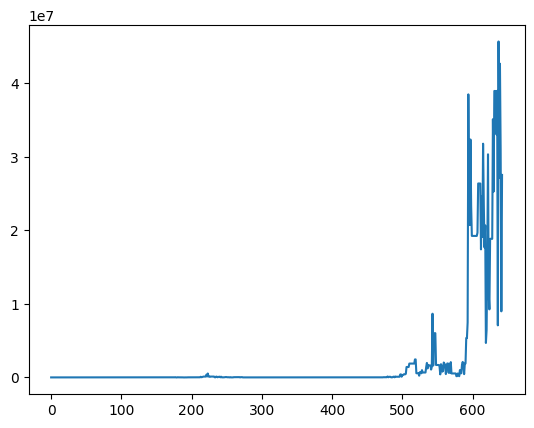

In [47]:
plt.plot(portfolio)